---

# **Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

### Introduction

#### Import libraries and other initial settings

In [1]:
import cv2
import glob
import numpy as np
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage.measurements import label

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from moviepy.editor import VideoFileClip

# Set a random seed for comparing runs
np.random.seed(seed=55)

#### Collect  images filenames - and distribute in training/vlidation/test sets

In [2]:
# Get vehicles and non-vehicles filenames as a list
def training_images_list(glob_file_path):
    images_list = glob.glob(glob_file_path)
    return images_list
               
all_cars    = training_images_list('vehicles/*/*.png') 
all_notcars = training_images_list('non-vehicles/*/*.png') 
        
# Select Train+Validation sample size and shares. Test set will take the remaining images
sample_size = 7500
valid_share = 0.2 

# Randomly select the cars and non-cars indexes
idx_cars =    np.random.choice(len(all_cars),    sample_size,replace=False)
idx_notcars = np.random.choice(len(all_notcars), sample_size,replace=False)

# Select test sample indexes as a complement of the training/validation 
other_idx_cars    = np.setdiff1d(np.arange(len(all_cars)),    idx_cars,   assume_unique=True)
other_idx_notcars = np.setdiff1d(np.arange(len(all_notcars)), idx_notcars,assume_unique=True)

# Select filenames for car and non cars for training/validation
cars    = list(np.array(all_cars)[idx_cars])
notcars = list(np.array(all_notcars)[idx_notcars])
# Select filenames for car and non cars for testing
cars_test    = list(np.array(all_cars)[other_idx_cars])
notcars_test = list(np.array(all_notcars)[other_idx_notcars])

print("Total vehicles:",  len(all_cars))
print("- of which:")
print("  vehicles for training:",len(cars))
print("  - of which:")
print("    validation (share) :",valid_share)
print("  vehicles for testing     :",len(cars_test))
print(" ")
print("Total non-vehicles:",len(all_notcars))
print("- of which:")
print("  non-vehicles for training:",len(notcars))
print("  - of which:")
print("    validation (share):",valid_share)
print("  non-vehicles for testing :",len(notcars_test))

Total vehicles: 8792
- of which:
  vehicles for training: 7500
  - of which:
    validation (share) : 0.2
  vehicles for testing     : 1292
 
Total non-vehicles: 8968
- of which:
  non-vehicles for training: 7500
  - of which:
    validation (share): 0.2
  non-vehicles for testing : 1468


---
### Histogram of Oriented Gradients (HOG) and other features


#### Functions for ectracting HOG, binned-color and color-hist features

In [3]:
# Code from `lesson_functions.py`      
# (see the lesson: Vehicle Detection and Tracking, track 32: "Search and Classify").

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    ''' returns HOG features and/or visualization '''
    
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return hog_features


def bin_spatial(img, size=(32, 32)):
    ''' Computes binned color features '''
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        

def color_hist(img, nbins=32, bins_range=(0, 256)):
    ''' Computes color histogram features'''
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def convert_RGB_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image) 
    return feature_image
    

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    ''' Define a function to extract features from a list of images
    This function call get_hog_features(), bin_spatial() and color_hist()
    '''
    # Create a list to append feature vectors to
    vector_features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # Apply color conversion if other than 'RGB'
        feature_image = convert_RGB_color(image, color_space = color_space)     

        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        vector_features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return vector_features
    

#### Parameters for extracting features

In [4]:
### Set parameters (image 64x64 pixels)

color_space    = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9         # HOG orientations
pix_per_cell   = 8        # HOG pixels per cell **2 (was 8)
cell_per_block = 2         # HOG cells per block **2
hog_channel    = 'ALL'         # Can be 0, 1, 2, or "ALL"

spatial_size   = (16, 16)  #(32, 32)  # Spatial binning dimensions

hist_bins      = 16        # Number of histogram bins (default 32)

# Select features
spatial_feat   = True      # Spatial features on or off
hist_feat      = False   # Histogram features on or off
hog_feat       = True      # HOG features on or off

# Set the number of randomly select features to be used 
feature_size = 3030 #2800


#### Extract features  

In [5]:
def reduce_features(some_features,idx):
    ''' Reduce the overall number of feature used (like dropout)
    Pick only some of the features as specified by the (idx) column index'''  
    
    some_features=np.array(some_features)
    some_features=some_features.transpose() [idx]
    some_features=list(some_features.transpose())
    return some_features

In [6]:
# Extract features from cars and non cars images
t0=time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(len(car_features[0]),'Car features ... extracted')

idx = np.random.choice(len(car_features[0]), feature_size)

car_features = reduce_features(car_features,idx)
print(len(car_features[0]),'Car features ... used')

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(notcar_features[0]),'Non car features ... extracted')
notcar_features = reduce_features(notcar_features,idx)
print(len(notcar_features[0]),'Non car features ... used')

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
t1 = time.time()

print('\nHOG parameters')
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print(round(t1-t0, 2), 'seconds to extract',len(car_features[0]),'features ...')
#%whos ndarray 

6060 Car features ... extracted
3030 Car features ... used
6060 Non car features ... extracted
3030 Non car features ... used

HOG parameters
Using: 9 orientations 8 pixels per cell and 2 cells per block
283.52 seconds to extract 3030 features ...


#### HOG visualization

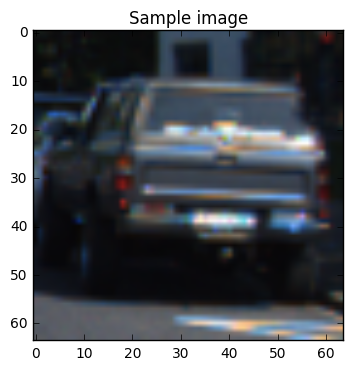

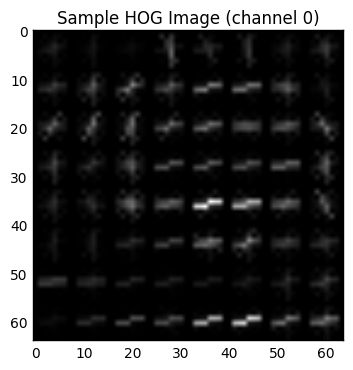

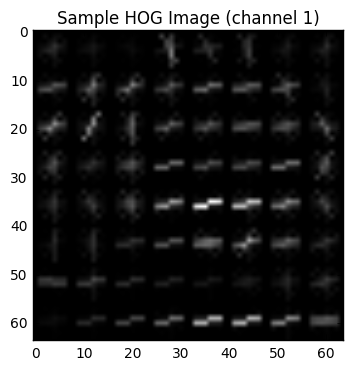

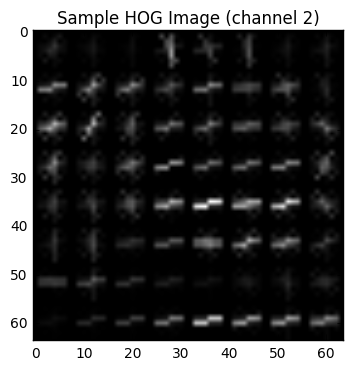

In [7]:
# Example: feature extraction on a sample image 
sample_image = mpimg.imread('vehicles/KITTI_extracted/78.png')
plt.imshow(sample_image)
plt.title("Sample image")    
plt.show()
mpimg.imsave('output_images/KITTI_sample78.png',sample_image)

# Hog-channel 0
sample_feature_vec, hog_sample = get_hog_features(sample_image[:,:,0], orient, pix_per_cell, 
                                                  cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_sample, cmap='gray')
plt.title("Sample HOG Image (channel 0)")
mpimg.imsave('output_images/KITTI_hog_sample78_0.png',hog_sample, cmap='gray')
plt.show()

# Hog-channel 1
sample_feature_vec, hog_sample = get_hog_features(sample_image[:,:,1], orient, pix_per_cell, 
                                                  cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_sample, cmap='gray')
plt.title("Sample HOG Image (channel 1)")
mpimg.imsave('output_images/KITTI_hog_sample78_1.png',hog_sample, cmap='gray')
plt.show()

# Hog-channel 2
sample_feature_vec, hog_sample = get_hog_features(sample_image[:,:,2], orient, pix_per_cell, 
                                                  cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_sample, cmap='gray')
plt.title("Sample HOG Image (channel 2)")
mpimg.imsave('output_images/KITTI_hog_sample78_2.png',hog_sample, cmap='gray')
plt.show()

---
### SVM classification

#### Preparing the dataset for the SVM classifier

In [8]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X);

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into temp randomized training and validation sets
rand_state = np.random.randint(0, 100)
X_train, X_valid, y_train, y_valid = train_test_split(scaled_X, y,test_size=valid_share,
                                                      random_state=np.random.randint(0, 100))
print ("Selected data set dimensions:",   scaled_X.shape,y.shape)
print ("Training set:                ",  X_train.shape,y_train.shape)
print ("Validation set:               ", X_valid.shape,y_valid.shape)

del scaled_X, y

Selected data set dimensions: (15000, 3030) (15000,)
Training set:                 (12000, 3030) (12000,)
Validation set:                (3000, 3030) (3000,)


#### Run Linear Support Vector Classification  

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.985 (+/-0.002) for {'C': 0.05}
0.985 (+/-0.002) for {'C': 0.1}
0.985 (+/-0.002) for {'C': 0.25}
0.985 (+/-0.002) for {'C': 0.5}
0.985 (+/-0.002) for {'C': 0.75}
0.985 (+/-0.002) for {'C': 1.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      1515
        1.0       0.99      0.99      0.99      1485

avg / total       0.99      0.99      0.99      3000



Temp training data set: (12000, 3030) (12000,)
     Train accuracy:  1.0
     Valid accuracy:   0.986

 Decision function: misclassified min/max: -5.99 6.08


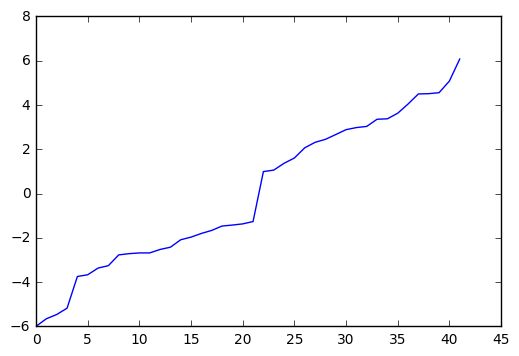

In [9]:
# Select classifier
svc = LinearSVC()

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.05,0.1,0.25,0.5,0.75,1.]}]

#  Code more than inspired by the GridSearchCV help 
scores = ['precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svc, tuned_parameters, cv=5,                       
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_pred = clf.predict(X_valid)
    print(classification_report(y_valid, y_pred))
    print()
            
    # Other monitoring indicators
    print('\nTemp training data set:',X_train.shape,y_train.shape)
    print('     Train accuracy: ', round(clf.score(X_train, y_train), 4))
    print('     Valid accuracy:  ', round(clf.score(X_valid, y_valid), 4))
    
    if (len(X_train[y_valid!=y_pred])>0):
        dec_fun = clf.decision_function(X_train[y_valid!=y_pred])
        print("\n Decision function: misclassified min/max:", round(min(dec_fun),2),round(max(dec_fun),2))
        plt.plot(np.sort(dec_fun))
        plt.show()

del   X_valid,y_valid,y_pred      

#### Trail log


|   Hog   | Training | Validation | Features |    svc   | BestC | 0_Prec. | 0_Recall| 1_Prec. | 1_Recall| decision (interval)   |
|:-------:|:--------:|:--------:|:--------:|:--------:|:-----:|:-------:|:-------:|:-------:|:-------:|:----------:|
|  YCrCb  | 12000 | 3000  |    8     | LinearSVC|  0.50 |   0.60  |   0.66  |   0.62  |   0.57  | -0.53 , 1.93 |
|  YCrCb  | 12000 | 3000  |  16      | LinearSVC|  0.50 |   0.69  |   0.69  |   0.70  |   0.70  | -2.15 , 1.42 |
|  YCrCb  | 12000 | 3000  |  32      | LinearSVC|  0.10 |   0.76  |   0.70  |    0.71 |   0.77  | -6.55 , 1.43 |
|  YCrCb  | 12000 | 3000  |  64      | LinearSVC|  0.05 |   0.88  |   0.90  |    0.90 |   0.88  | -4.26 , 3.64 |
|  YCrCb  | 12000 | 3000  | 128      | LinearSVC|  0.50 |   0.92  |   0.92  |    0.92 |   0.92  | -3.71 , 4.92 |
|  YCrCb  | 12000 | 3000  | 256      | LinearSVC|  0.50 |   0.96  |   0.97  |    0.97 |   0.95  | -5.19 , 3.9  |
|  YCrCb  | 12000 | 3000  | 512      | LinearSVC|  0.05 |   0.98  |   0.97  |    0.97 |   0.98  | -8.23 , 11.51|
|**YCrCb**| 12000 | 3000  |**1024**  | LinearSVC|  0.05 |   0.98  |   0.98  |    0.98 |   0.98  | -17.33 , 8.21|
|**HSV**  | 12000 | 3000  |**1024**  | LinearSVC|  0.05 |   0.98  |   0.98  |    0.98 |   0.98  | -10.26 , 9.87|
|  HLS    | 12000 | 3000  |  1024    | LinearSVC|  0.05 |   0.97  |   0.98  |    0.98 |   0.97  | -9.3 , 11.38 |
|  YCrCb  | 12000 | 3000  |  2048    | LinearSVC|  0.05 |   0.98  |   0.99  |    0.99 |   0.98  | -9.8 , 6.15  |
|**YCrCb**| 13500 | 1500  |**2048**  | LinearSVC|  0.25 | **0.99**| **0.99**| **0.99**| **0.98**| -11.63 , 6.78|
|**HSV**  | 13500 | 1500  |**2048**  | LinearSVC|  0.10 | **0.98**| **0.98**| **0.98**| **0.98**| -6.73 , 6.46 |
|  YCrCb  | 13500 | 1500  |  2400    | LinearSVC|  0.05 |   0.99  |   0.99  |    0.99 |   0.99  | -6.50 , 5.36 |
|  YCrCb  | 13500 | 1500  |  2800    | LinearSVC|  0.05 |   0.99  |   0.99  |    0.99 |   0.99  | -7.39 , 6.79 |
|  YCrCb  | 12000 | 3000  |  3030    | LinearSVC|  0.05 |   0.99  |   0.99  |    0.99 |   0.99  | -5.45 , 5.45 |


#### Test the model on the "set already aside" test sample

In [10]:
# Testing 
cars_test_features = extract_features(cars_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(cars_test_features[0]),'cars_test_features ... original')
cars_test_features = reduce_features(cars_test_features,idx)
print(len(cars_test_features[0]),'cars_test_features ... actual')

notcars_test_features = extract_features(notcars_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(notcars_test_features[0]),'notcars_test_features ... original')
notcars_test_features = reduce_features(notcars_test_features,idx)
print(len(notcars_test_features[0]),'notcars_test_features ... actual')


X_test = np.vstack((cars_test_features, notcars_test_features)).astype(np.float64)
y_test = np.hstack((np.ones(len(cars_test_features)), np.zeros(len(notcars_test_features))))
# Apply the scaler to X
scaled_X_test = X_scaler.transform(X_test);

y_pred = clf.predict(scaled_X_test)
print(classification_report(y_test, y_pred))
print()
    
        
# Still monitoring
print('\nTemp training data set:',X_train.shape,y_train.shape)
print('     Train accuracy: ', round(clf.score(X_train, y_train), 4))
print('     Test accuracy:  ', round(clf.score(scaled_X_test, y_test), 4))

6060 cars_test_features ... original
3030 cars_test_features ... actual
6060 notcars_test_features ... original
3030 notcars_test_features ... actual
             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99      1468
        1.0       0.99      0.98      0.98      1292

avg / total       0.98      0.98      0.98      2760



Temp training data set: (12000, 3030) (12000,)
     Train accuracy:  1.0
     Test accuracy:   0.9843


In [11]:
#### Reduce memory pressure

In [12]:
# Free some memory (if set to True)
if True:
    del X_train,y_pred,y_train
    del X_test,scaled_X_test,y_test
    del X, dec_fun,idx_cars,idx_notcars,means,other_idx_cars,other_idx_notcars,stds
    del hog_sample, sample_feature_vec, sample_image
#%whos ndarray 

---
### Sliding Window Search

#### Functions for finding cars in a single image (via HOG and SVM)

In [13]:
# Single function (from lesons) that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              color_space,hog_channel,cells_per_step,idx,spatial_feat=True,hist_feat=False,clip = False):
    
    bbox_list=[]
    out_img = np.copy(img)
    
    if clip:
        img = img.astype(np.float32)/255  
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_RGB_color(img_tosearch, color_space=color_space)    
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if (hog_channel=='ALL'):
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    nblocks_per_window = (window // pix_per_cell)-1 
    
    #cells_per_step = 2  # Instead of overlap, define how many cells to step (2)
        
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if (hog_channel=='ALL'):
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            #count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if (hog_channel=='ALL'):
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = np.hstack((hog_feat1))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            if hist_feat:
                test_features = X_scaler.transform(np.hstack((
                    hist_features,hog_features,spatial_features)).reshape(1, -1)) 
            else:
                temp = np.hstack((hog_features,spatial_features)).reshape(1, -1)
                temp = reduce_features(temp,idx)
                test_features = X_scaler.transform(temp) 
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(out_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,1.),6) 
                bbox_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    
    #print("Number of windows examined:",count)
    
    return out_img,bbox_list
    

#### Functions for heat-mapping

In [14]:
# Function from the lessons that can extract features using hog sub-sampling and make predictions

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels, clip = False, thickness=4):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if clip:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), thickness)
        else:
            cv2.rectangle(img, bbox[0], bbox[1], (0.,0.,1.), thickness)

    # Return the image
    return img


def draw_boxes(img, bboxes, color=(0., 0., 1.), thick=6):
    ''' Define a function to draw bounding boxes'''
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


#### Function for tuning search

In [15]:
def clear_undersized_rectancle(d1,d2):
    ''' Clear rectangles less than min_area wide'''    
    min_area = 64*64
    if (d1*d2)<min_area:
        return True # rectangle will disappear
    else:
        return False #there is a "big" rectangle
    
def exist_rectangle(boxes,sized_rect):
    ''' Check the existence of overlapping frames and select one'''

    ax = sized_rect[0][0]
    ay = sized_rect[0][1]
    bx = sized_rect[0][0]
    by = sized_rect[1][1]
    cx = sized_rect[1][0]
    cy = sized_rect[1][1]
    dx = sized_rect[1][0]
    dy = sized_rect[0][1]
    
    for i in range(len(boxes)):
        box = boxes[i]
        
        if((ax >= box[0][0]) & (ax <= box[1][0]) & (ay >= box[0][1]) & (ay <= box[1][1]) | \
           (bx >= box[0][0]) & (bx <= box[1][0]) & (by >= box[0][1]) & (by <= box[1][1]) | \
           (cx >= box[0][0]) & (cx <= box[1][0]) & (cy >= box[0][1]) & (cy <= box[1][1]) | \
           (dx >= box[0][0]) & (dx <= box[1][0]) & (dy >= box[0][1]) & (dy <= box[1][1]) ): 
            return True
        
    return False

def size_rectangle (labels, half_h, half_v):
    ''' Create a standrd rectangle around the midponint of 
    labels resulting from a heat map
    if rectangle is at least min_size x min_size'''
    
    my_box = []
    for i in range(labels[1]):
        n_rect = i + 1
        d1 = np.max((labels[0]==n_rect).nonzero()[0])- np.min((labels[0]==n_rect).nonzero()[0])
        d2 = np.max((labels[0]==n_rect).nonzero()[1])- np.min((labels[0]==n_rect).nonzero()[1])
        if (clear_undersized_rectancle(d1,d2)):
            continue        
        h = np.int((np.min((labels[0]==n_rect).nonzero()[1])+np.max((labels[0]==n_rect).nonzero()[1]))/2)
        v = np.int((np.min((labels[0]==n_rect).nonzero()[0])+np.max((labels[0]==n_rect).nonzero()[0]))/2)
        sized_rect = [(h-half_h,v-half_v),(h+half_h,v+half_v)]
        if (exist_rectangle(my_box,sized_rect)):
            pass
        else:
            my_box.append(sized_rect)
            
    return my_box


#### Parameters for sliding windows 

In [16]:
# Selecting the area of the image where cars can be
# and the dimensions of the searcing squared frames (here the array has 4 elements) 

# Vertical (y axis) top limit where start search (for each of the 4 squared frames)
ystarts =             [400, 430,  440]      # top reference to start sliding

# How big are the frame with respect to the standard 64x64 pixel
scales  =             [.8,   1.2,  1.5]      # how much yo scale sub images
len_scales = len(scales)

# Set the number rows (from the top limit) where windows slide   
rows    = np.multiply([2.,  2.,   1.] ,64) # how many rows to slide from top

# Calculate the bottom line where stop searching
ystops  = np.add(ystarts,np.multiply(scales,rows)).astype(int) #bottom reference


# Set the overlapping 
cells_per_step = 2


#### Parameters for the heat-map

In [17]:
# Set the heatmap threshold to select frames that identifiy cars
heat_threshold = 2


---
#### Pipeline for a single image
#### 1. Read the image

In [18]:
image = mpimg.imread('test_images/test6.jpg')
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255.
draw_image = np.copy(image)

#### 2.  Apply HOG and SVM to find cars

In [19]:
# Set the list containing box references
bbox_list=[]

t0=time.time()

# Repeat for each scale factor used in sliding
for i in np.arange(len_scales):
    
    scale = scales [i]
    ystart= ystarts[i]
    ystop = ystops [i]
        
    _,bbox_list_temp = find_cars(draw_image, ystart, ystop, scale,
                                 clf, X_scaler, 
                                 orient, pix_per_cell, cell_per_block,
                                 spatial_size, hist_bins,
                                 color_space, hog_channel,cells_per_step, idx,
                                 spatial_feat=True,hist_feat=False)
    
    bbox_list.extend(bbox_list_temp)

t1 = time.time()
print(round(t1-t0, 2), 'seconds to find car(s)...')

0.74 seconds to find car(s)...


#### 3. Build a heat map to detect cars and outliers 

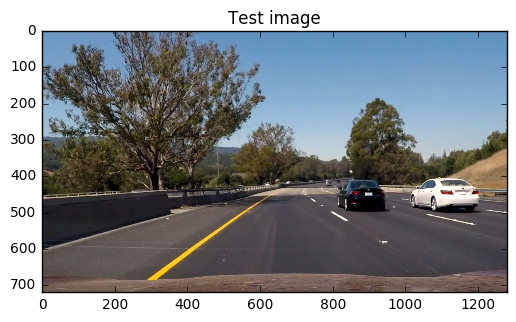

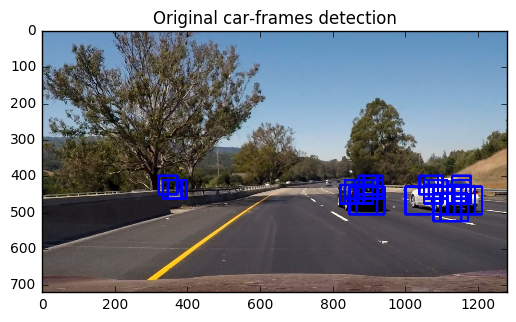

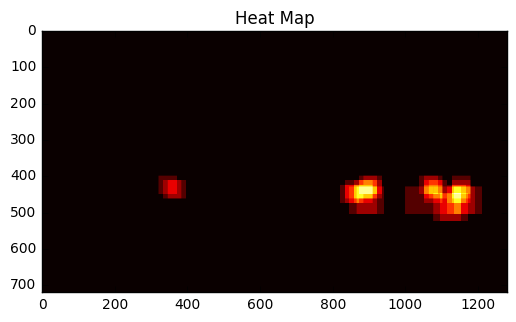

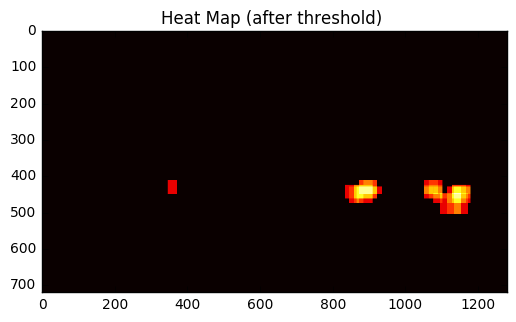

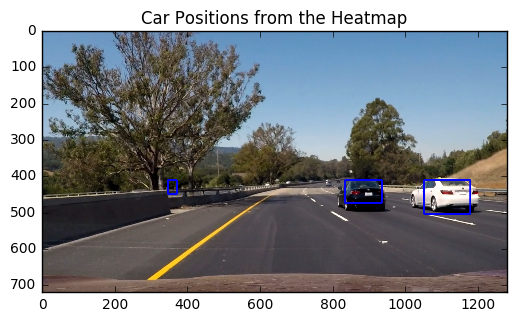

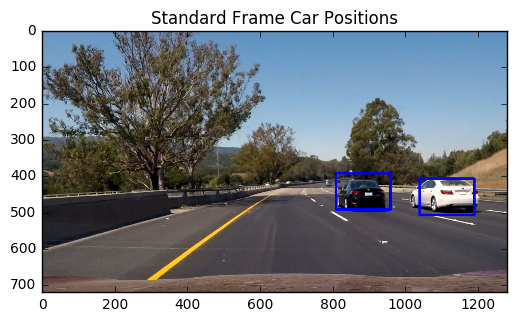

In [20]:
# Show the "original" image
plt.imshow(image)
plt.title("Test image")
mpimg.imsave('output_images/My_test_image.jpg',image)
plt.show()

# Show the "first" frame detection
out_img = draw_boxes(draw_image,bbox_list)
plt.imshow(out_img)
plt.title('Original car-frames detection')
mpimg.imsave('output_images/Raw_detection.jpg',out_img)
plt.show()

# Create an image similar to one shown above 
heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
plt.imshow(heat, cmap='hot')
plt.title('Heat Map')
mpimg.imsave('output_images/Heat_map.jpg',heat,cmap='hot')
plt.show()
   
# Apply threshold to help remove false positives
heat = apply_threshold(heat,heat_threshold)

plt.imshow(heat, cmap='hot')
plt.title('Heat Map (after threshold) ')
mpimg.imsave('output_images/Heat_map_w_threshold.jpg',heat, cmap='hot')
plt.show()

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find initial boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)
plt.title('Car Positions from the Heatmap')
mpimg.imsave('output_images/Heat_car_positions.jpg',draw_img)
plt.show()

# Resize boxes with a "standard" box
new_labels = size_rectangle (labels,75,50)

# Draw final boxes from heatmap using label function
draw_img = draw_boxes(np.copy(image), new_labels)

plt.imshow(draw_img)
plt.title('Standard Frame Car Positions')
mpimg.imsave('output_images/Final_car_positions.jpg',draw_img)
plt.show()


---
### Video Implementation

In [21]:
def process_image(video_img):
    
    global heat_memory
    
    # Empty list of upper-left lower-rigth points of rectangles
    bbox_list_clip = []
    draw_image = np.copy(video_img)
    
    # Apply HOG and SVM to find cars with sliding windows    
    for i in np.arange(len_scales):    
        scale = scales [i]
        ystart= ystarts[i]
        ystop = ystops [i]
        
        _,bbox_list_temp_clip = find_cars(draw_image, ystart, ystop, scale, 
                                          clf, X_scaler,
                                          orient, pix_per_cell, cell_per_block, 
                                          spatial_size, hist_bins,
                                          color_space, hog_channel,cells_per_step, idx,
                                          spatial_feat=True,hist_feat=False,clip = True)
        bbox_list_clip.extend(bbox_list_temp_clip)
   
    # Create an image similar to the video image 
    heat_clip = np.zeros_like(video_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat_clip = add_heat(heat_clip,bbox_list_clip) 
   
    # Add car frames from previous images to the heat
    for i in np.arange(len(heat_memory)):
        heat_clip = add_heat(heat_clip,heat_memory[i])
    
    # Apply an increased threshold to remove outliers   
    heat_clip = apply_threshold(heat_clip,heat_threshold + 4)        

    # Visualize the heatmap when displaying    
    heatmap_clip = np.clip(heat_clip, 0, 255)
    
    # Find boxes from heatmap using label function
    labels_clip = label(heatmap_clip)

    # Draw boxes around car with a "standard" rectangle
    new_labels  = size_rectangle (labels_clip,80,40)  
       
    # Create result image to display in the video 
    result = draw_boxes(draw_image, new_labels, color=(0, 0, 255)) 
    
    # Rearrange history/stack frames 
    for i in np.arange(len(heat_memory)-1):
        heat_memory[i] = np.copy(heat_memory[i+1])
    # Update stack
    heat_memory[len(heat_memory)-1] = np.copy(bbox_list_clip) 
        
    return result

In [22]:
# Set a list to store previous frames
n_frames = 6
heat_memory = list([] for i in np.arange(n_frames))

# Apply car detection to video-clip
white_output = 'my_project5_video.mp4'
#clip1 = VideoFileClip("test_video.mp4") 
clip1 = VideoFileClip("project_video.mp4") #.subclip(40,42)

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output,audio=False)

[MoviePy] >>>> Building video my_project5_video.mp4
[MoviePy] Writing video my_project5_video.mp4


100%|█████████▉| 1260/1261 [17:50<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_project5_video.mp4 

CPU times: user 16min 28s, sys: 1min 14s, total: 17min 42s
Wall time: 17min 53s


---